In [74]:
import os
import quandl
import pickle
quandl.ApiConfig.api_key = 'JJH1Z7c2NDeRw278rr6H'
import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn

In [65]:
def fetch_cosine_values(seq_len, frequency = 0.01, noise = 0.1):
    np.random.seed(101)
    x = np.arange(0.0, seq_len, 1.0) #numpy.arange([start, ] stop, [step, ] dtype=None)
    return np.cos(2 * np.pi *frequency * x) + np.random.uniform(low = noise, high = noise, size = seq_len)
    

In [76]:
#datetime.date를 API에서 필요로 하는 문자열 형식으로 변환하는 함수
def date_obj_to_str(date_obj):
    return date_obj.strftime('%Y-%m-%d')
def save_pickle(something, path):
    if not os.path.exists(os.path.dirname(path)):
        os.makedirs(os.path.dirname(path))
    with open(path, 'wb') as fh:
        pickle.dump(something, fh, pickle.DEFAULT_PROTOCOL)
def load_pickle(path):
    with open(path, 'rb') as fh:
        return pickle.load(fh)

#from_date에서 to_date로 졍렬되어, 요청한 종목 기호에 대한 주가를 포함한 일차원 배열을 반환
def fetch_stock_price(symbol, from_date, to_date, cache_path='./tmp/prices/'):
    assert from_date <= to_date, "from_date가 to_date보다 큼!"
    
    filename = "{}_{}_{}.pk".format(symbol, str(from_date),str(to_date))
    price_filepath = os.path.join(cache_path, filename)
    
    try:
        prices = load_pickle(price_filepath)
        print("loaded from", price_filepath)
    except IOError:
        historic = quandl.get("WIKI/"+symbol,
                             start_date = date_obj_to_str(from_date),
                             end_date = date_obj_to_str(to_date))
        prices = historic["Adj. Close"].tolist()
        save_pickle(prices, price_filepath)
        print("saved into", price_filepath)
    return prices

In [26]:
def format_dataset(values, temporal_features):
    feat_splits = [values[i:i+temporal_features] for i in range(len(values)-temporal_features)]
    feats = np.vstack(feat_splits) #두 배열을 위에서 아래로 붙이기
    labels = np.array(values[temporal_features:])
    return feats,labels

#### print 2 oscillations (20 points, with a frequency of 0.1, a period of 10)  

In [4]:
np.set_printoptions(precision=2) #numpy 출력 format 설정 (소수점 둘쨰)

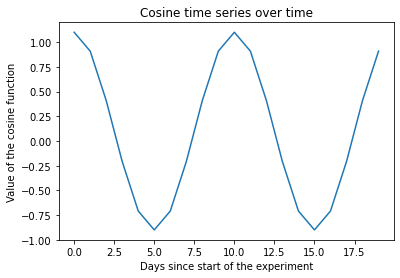

In [66]:
cos_values = fetch_cosine_values(20,frequency=0.1)
plt.plot(cos_values) #책에 있는 seaborn.tsplot은 새로운 버전에서 제거됨
plt.xlabel("Days since start of the experiment")
plt.ylabel("Value of the cosine function")
plt.title("Cosine time series over time")
plt.show()

#### 주가 형성 및, 관측벡터와 레이블 벡터

In [37]:
feature_size = 5
minibatch_cos_X, minibatch_cos_Y = format_dataset(cos_values, feature_size)
print("minibatch_cos_X.shape=",minibatch_cos_X.shape)
print("minibatch_cos_Y.shape=",minibatch_cos_Y.shape)

minibatch_cos_X.shape= (15, 5)
minibatch_cos_Y.shape= (15,)


Observation 0: X=[ 1.1   0.91  0.41 -0.21 -0.71] y=-0.9
Observation 1: X=[ 0.91  0.41 -0.21 -0.71 -0.9 ] y=-0.7090169943749475
Observation 2: X=[ 0.41 -0.21 -0.71 -0.9  -0.71] y=-0.20901699437494756
Observation 3: X=[-0.21 -0.71 -0.9  -0.71 -0.21] y=0.4090169943749472
Observation 4: X=[-0.71 -0.9  -0.71 -0.21  0.41] y=0.9090169943749473
Observation 5: X=[-0.9  -0.71 -0.21  0.41  0.91] y=1.1
Observation 6: X=[-0.71 -0.21  0.41  0.91  1.1 ] y=0.9090169943749475
Observation 7: X=[-0.21  0.41  0.91  1.1   0.91] y=0.40901699437494776
Observation 8: X=[0.41 0.91 1.1  0.91 0.41] y=-0.2090169943749471
Observation 9: X=[ 0.91  1.1   0.91  0.41 -0.21] y=-0.7090169943749473
Observation 10: X=[ 1.1   0.91  0.41 -0.21 -0.71] y=-0.9
Observation 11: X=[ 0.91  0.41 -0.21 -0.71 -0.9 ] y=-0.7090169943749477
Observation 12: X=[ 0.41 -0.21 -0.71 -0.9  -0.71] y=-0.20901699437494783
Observation 13: X=[-0.21 -0.71 -0.9  -0.71 -0.21] y=0.409016994374947
Observation 14: X=[-0.71 -0.9  -0.71 -0.21  0.41] y=0.90

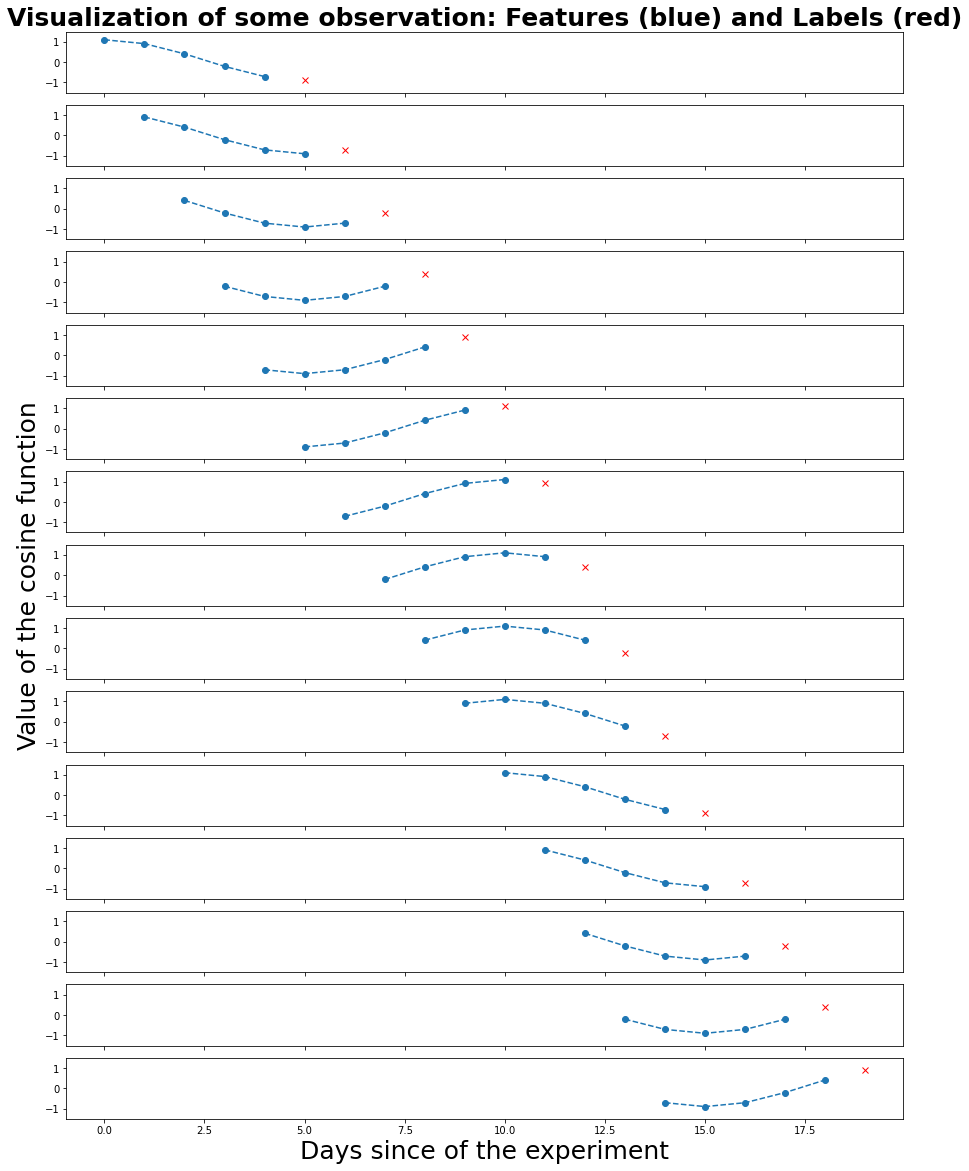

In [62]:
samples_to_plot = 15
f, axarr = plt.subplots(samples_to_plot, sharex = True, figsize=(15,20)) #x축 공유
#위의 subplot부터 axarr[0]임, f는 전체 큰 figure 자체
for i in range(samples_to_plot):
    feats = minibatch_cos_X[i,:]
    label = minibatch_cos_Y[i]
    
    print("Observation {}: X={} y={}".format(i,feats,label))
    
    axarr[i].plot(range(i,feature_size+i), feats, '--o')
    axarr[i].plot([feature_size+i],label,'rx') #red x표
    axarr[i].set_ylim([-1.5, 1.5])

plt.xlabel("Days since of the experiment", fontsize = 25)
ylabel_loc = int(samples_to_plot/2)
axarr[ylabel_loc].set_ylabel("Value of the cosine function", fontsize = 25)
axarr[0].set_title("Visualization of some observation: Features (blue) and Labels (red)", fontsize = 25,
                  fontweight='bold')
plt.show()

#### 실제 주가 정보 가져와서 똑같이 plotting 

loaded from ./tmp/prices/KO_2015-01-01_2016-12-31.pk
loaded from ./tmp/prices/AAL_2015-01-01_2016-12-31.pk
loaded from ./tmp/prices/MMM_2015-01-01_2016-12-31.pk
loaded from ./tmp/prices/AXP_2015-01-01_2016-12-31.pk
loaded from ./tmp/prices/GE_2015-01-01_2016-12-31.pk
loaded from ./tmp/prices/GM_2015-01-01_2016-12-31.pk
loaded from ./tmp/prices/JPM_2015-01-01_2016-12-31.pk
loaded from ./tmp/prices/UPS_2015-01-01_2016-12-31.pk


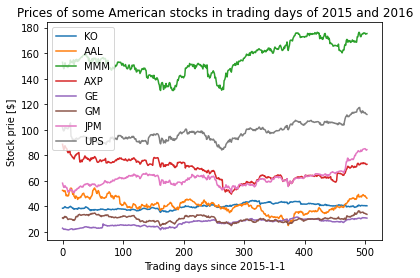

In [95]:
symbols = ['KO','AAL',"MMM",'AXP','GE','GM','JPM',"UPS"]
ax = plt.subplot(1,1,1)
for sym in symbols:
    prices = fetch_stock_price(sym, datetime.date(2015,1,1), datetime.date(2016,12,31))
    ax.plot(range(len(prices)),prices,label=sym)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles,labels)
plt.xlabel("Trading days since 2015-1-1")
plt.ylabel("Stock prie [$]")
plt.title("Prices of some American stocks in trading days of 2015 and 2016")
plt.show()